In [2]:
#Import the neccassary libraries. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Import the excel file.
pol_data = pd.ExcelFile('Project Pollinator Count Data Collection Sheet 2022.xlsx')

#Select the sheet of interest and create a dataframe based off the sheet. 
df_pol_sh1 = pd.read_excel(pol_data, 'Summer 2022 Pollinator Data Col')

df_pol_sh1.replace('total_shade', 'full_shade', inplace=True)

In [4]:
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator']

In [5]:
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('HB', 'Honey Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BVO', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('HF', 'Hover Fly')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('SB', 'Sweat Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BFL', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BME', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BMI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BS', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BVO', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BU', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BB', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BUT', 'Butterfly')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BMI', 'Bumble Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('LB', 'Leafcutter Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('MB', 'Leafcutter Bee')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('W', 'Wasp')
df_pol_sh1['pollinator_group'] = df_pol_sh1['pollinator_group'].replace('BF', 'Fly')
df_pol_sh1.loc[(df_pol_sh1['pollinator'] == 'OP') & (df_pol_sh1['insect_order'] == 'diptera'), 'pollinator_group'] = 'Fly'
df_pol_sh1.loc[(df_pol_sh1['pollinator'] == 'OP') & (df_pol_sh1['insect_order'] == 'coleoptera'), 'pollinator_group'] = 'Beetle'
index_names = df_pol_sh1[(df_pol_sh1['pollinator_group'] == 'NI') | (df_pol_sh1['pollinator_group'] == 'OP') | (df_pol_sh1['pollinator_group'] == 'UB')].index
df_pol_sh1.drop(index_names, inplace = True)


In [6]:
df_pol_sh1['pollinator_group'].value_counts()

Bumble Bee        597
Honey Bee         581
Hover Fly         304
Sweat Bee         267
Wasp               48
Fly                46
Leafcutter Bee     29
Butterfly          17
Beetle             14
Name: pollinator_group, dtype: int64

In [7]:
df_pol_sh1.groupby(df_pol_sh1['pollinator_group'])['insect_order'].value_counts()

pollinator_group  insect_order
Beetle            coleoptera       14
Bumble Bee        hymenoptera     596
                  diptera           1
Butterfly         lepidoptera      17
Fly               diptera          46
Honey Bee         hymenoptera     581
Hover Fly         diptera         304
Leafcutter Bee    hymenoptera      29
Sweat Bee         hymenoptera     267
Wasp              hymenoptera      48
Name: insect_order, dtype: int64

In [8]:
#Make a function that makes a dict of column names and their associated index from an inputed dataframe. 
def Dict_of_column_NameIndex(dataframe):
    
    column_names = []
    column_index = []

    for name in dataframe.columns: 
        column_names.append(name)
    
    for name in dataframe.columns:
        column_index.append(dataframe.columns.get_loc(name)) 
    
    dict_column_index = dict(zip(column_names, column_index))

    return dict_column_index

In [9]:
#Run the function to create a dict. 
dict_column_index = Dict_of_column_NameIndex(df_pol_sh1)

#Print the dict in an alligned format. 
for key, value in dict_column_index.items():
    print('{: >35} {: >3}'.format(key, value))

                        sample_date   0
                     collector_name   1
                           location   2
                    location_number   3
                  time_code (M,A,E)   4
                       sample_start   5
                         sample_end   6
                            weather   7
                       wind (km/hr)   8
                       air_temp(C°)   9
                     shade_coverage  10
                     observation_id  11
                         pollinator  12
                       insect_order  13
                      insect_family  14
                       insect_genus  15
                     insect_species  16
                         plant_host  17
                        plant_order  18
                       plant_family  19
                        plant_genus  20
                      plant_species  21
                        plant_color  22
                      plant_pattern  23
                  Photo reference #  24


Figure 1: This figure takes the percentage difference of both the average number of visitations of pollinators and the mean temperature for each 7 day period from June 12 to Sept 11th. 

Mean visitionsation: Calucalted for each week by taking the total number of visitation for that week and dividing it 
by the total number of survey locations that were sampled in that week and does that for each week. 

Mean Temperature: Calulated by adding all the temperatures for a week together and then dividing it by the number of visitations. 

In [10]:
# A function that intakes a df column and returns a list of the percent differences with the first value being 
#the baseline percentage of 100.

def turn_into_percent_difference(old_series):
    initial_value = old_series[0]
    new_list = []
    for index in old_series:
        new_list.append((index/ initial_value)*100)
    return new_list

In [79]:
def average_per_week(request):

	#Creating bins, each bin will be a week starting on May 16, 2022, and going for 18 weeks. 
	bins = pd.date_range(start='2022-05-15', freq='1W', periods=18)

	#Creating A column with the binned categorization. 
	df_pol_sh1['binned_week'] = pd.cut(df_pol_sh1['sample_date'], bins = bins)

	# #find the total number of pollinators according to location number and time code
	if(request == 'average'):
		series_mean = df_pol_sh1['binned_week'].value_counts() / df_pol_sh1.groupby('binned_week')['location_number'].nunique()
	else:
		df_pol_sh1_request = df_pol_sh1[(df_pol_sh1['pollinator_group'] == request)]
		series_mean = df_pol_sh1_request ['binned_week'].value_counts() / df_pol_sh1_request .groupby('binned_week')['location_number'].nunique()

	#Gets the mean temperature per week and turns it into a series. 
	series_mean_temp = df_pol_sh1.groupby('binned_week')['air_temp(C°)'].mean()

	df_mean = pd.DataFrame(series_mean)
	df_mean_temp = pd.DataFrame(series_mean_temp)
	df_mean.fillna(0, inplace=True)

	# Conveting the series into dataframes and while not including the first 4 weeks. 

	df_mean['Abundance_percentage'] = turn_into_percent_difference(df_mean[0])
	df_mean['Temp_percentage'] = turn_into_percent_difference(df_mean_temp['air_temp(C°)'])

	#Dropping the original mean column. 

	df_mean = df_mean.drop(0, axis=1)

	#Adding a new index column that is a single data format instead of a data range and 
	# converting it to a string of Mon, day, year format. 

	df_mean['date'] = bins[1:]
	df_mean.set_index(["date"],inplace=True)
	df_mean.index = df_mean.index.strftime("%b %d, %Y")

	#Plotting both percentage difference of visitations and temperature of weeks. 

	fig, ax = plt.subplots()
	ax.plot(df_mean.index, df_mean['Abundance_percentage'], linewidth=3, color='#63B7B7')
	ax.plot(df_mean.index, df_mean['Temp_percentage'], linewidth=3, color='#FF6961')
	plt.xticks(rotation = 60, horizontalalignment='right')
	ax.legend(['Visitations', 'Temperature'])
	ax.set_ylabel('Percent Difference (%)')
	ax.set_xlabel('Week')
	ax.set_title('Percent Difference of Average Visition Number and \n Temperature For Each Week Between June 12 and September 11th.',
				fontname = 'Georgia', 
				fontsize= 16, 
				pad=30)
	ax.grid()
	#ax.tick_params(axis='both', length = 10, width = 2)
	#yticks = np.linspace(0, 220, num=12)
	#ax.set_yticks(yticks)
	
	plt.show()

In [12]:
df_shade_pol_abundance_less24= df_pol_sh1[df_pol_sh1['air_temp(C°)'] < 24]
df_shade_pol_abundance_less24 = pd.DataFrame(df_shade_pol_abundance_less24.groupby('location')[['shade_coverage', 'location']].value_counts())
df_shade_pol_abundance_less24

0
location         shade_coverage     
Community_Garden no_shade        169
                 partly_shade    151
                 full_shade      110
                 mostly_shade     63
Library          partly_shade    143
                 no_shade         86
                 mostly_shade     81
Student_Union    no_shade        528
                 mostly_shade     40

In [13]:
df_shade_pol_abundance_greatEqual24= df_pol_sh1[df_pol_sh1['air_temp(C°)'] >= 24]
df_shade_pol_abundance_greatEqual24 = pd.DataFrame(df_shade_pol_abundance_greatEqual24.groupby('location')[['shade_coverage', 'location']].value_counts(dropna=False))
df_shade_pol_abundance_greatEqual24

0
location         shade_coverage     
Community_Garden partly_shade    143
                 no_shade         72
                 mostly_shade     35
                 full_shade       20
Library          partly_shade     41
                 mostly_shade     39
                 no_shade          2
Student_Union    no_shade        180

In [14]:
df_shade_pol_abundance_greatEqual24 = df_shade_pol_abundance_greatEqual24.unstack()
df_shade_pol_abundance_less24 = df_shade_pol_abundance_less24.unstack()
df_shade_pol_abundance_less24 = df_shade_pol_abundance_less24.fillna(0)


In [15]:
df_shade_pol_abundance_less24

0                                   
shade_coverage   full_shade mostly_shade no_shade partly_shade
location                                                      
Community_Garden      110.0         63.0    169.0        151.0
Library                 0.0         81.0     86.0        143.0
Student_Union           0.0         40.0    528.0          0.0

In [16]:
#pd.DataFrame(df_shade_pol_abundance_less24)

<Axes: xlabel='location'>

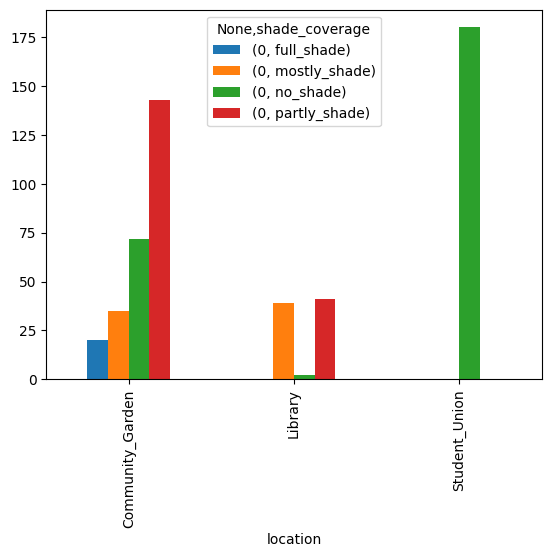

In [17]:
df_shade_pol_abundance_greatEqual24.plot(kind='bar')

<Axes: xlabel='location'>

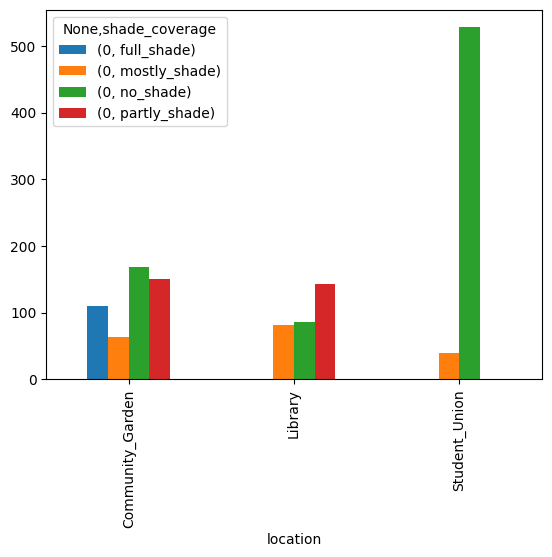

In [18]:
df_shade_pol_abundance_less24.plot(kind='bar')

In [38]:
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import widgets
from ipywidgets import interact


In [37]:
df_pol_sh1['pollinator_group'].unique()

array(['Bumble Bee', 'Fly', 'Butterfly', 'Honey Bee', 'Hover Fly',
       'Leafcutter Bee', 'Beetle', 'Sweat Bee', 'Wasp'], dtype=object)

C:\Users\keega\AppData\Local\Temp\ipykernel_4516\3802321212.py:8: RuntimeWarning: invalid value encountered in scalar divide
  new_list.append((index/ initial_value)*100)
C:\Users\keega\AppData\Local\Temp\ipykernel_4516\3802321212.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  new_list.append((index/ initial_value)*100)


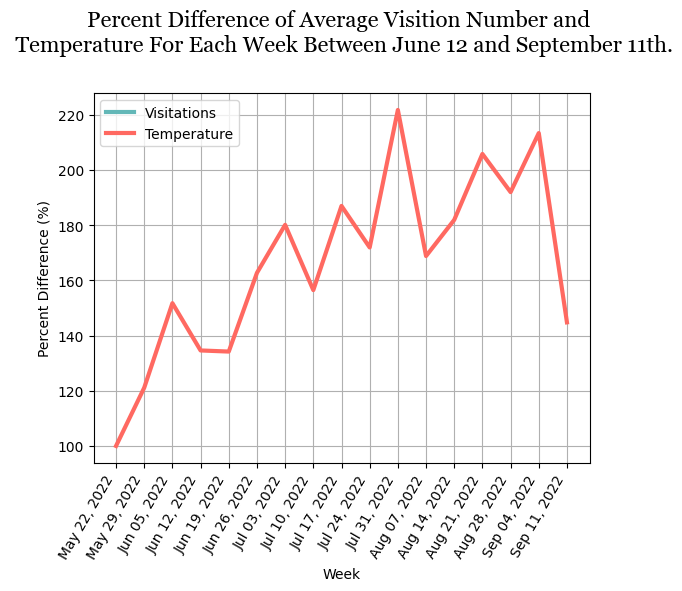

In [80]:
average_per_week('Bumble Bee')

In [39]:
widgets.interact(average_per_week,request = df_pol_sh1['pollinator_group'].unique())

interactive(children=(Dropdown(description='request', options=('Bumble Bee', 'Fly', 'Butterfly', 'Honey Bee', …

<function __main__.average_per_week(request)>

In [ ]:
import datetime
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import widgets
from ipywidgets import interact

df = pd.read_csv(
    "https://raw.githubusercontent.com/yankev/testing/master/datasets/nycflights.csv"
)
df = df.drop(df.columns[[0]], axis=1)

@interact
def view_image(
    col=widgets.Dropdown(
        description="Plot:", value="carrier", options=["origin", "carrier"]
    ),
    filtercol=widgets.Dropdown(
        description="Filter by:", value="carrier", options=["origin", "dest", "carrier"]
    ),

    filter=widgets.Text(
        description="Filter:", value=""
    ),
):
    # check if filter results in any rows... if not all data...
    if df[filtercol].eq(filter).any():
        dfp = df.loc[df[filtercol].eq(filter)]
    else:
        dfp = df
    fig = px.box(dfp, x=col, y="distance", color=col)
    go.FigureWidget(fig.to_dict()).show()

In [ ]:
#using ipywidgets
#data_set, request

create information for slider
#adding widget for sliding months to get specific range of month
dates = df_['date'].unique()
dates = np.sort(dates)
#print('Test Case 1: \n',type(dates))
#print('Test Case 2: \n',dates)
month = []
for i in dates:
    month.append(calendar.month_name[i])
#months = [(calendar.month_name[i]) for i in dates]
print(month)

#create slider for the informtion 
widgets.SelectionRangeSlider(
    options = month,
    index =(0,4),
    description = 'Months',
    disabled = False
)

NameError: name 'average_per_week' is not defined

In [ ]:
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="linear"
    )
)

fig.show()